In [139]:
!pip install -q gymnasium[classic-control]


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [137]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [ ]:
#creating the gym env
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42)

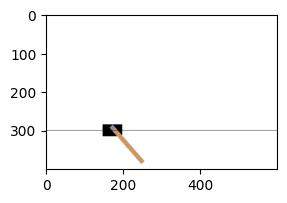

In [ ]:
action=0
obs, reward, done, truncated, info = env.step(action=action)
img=env.render()

plt.figure(figsize=(3, 2))
plt.imshow(img)